In [1]:
from pydrake.all import (
    ConstantVectorSource,
    DiagramBuilder,
    LogVectorOutput,
    MeshcatVisualizer,
    SceneGraph,
    Simulator,
    StartMeshcat,
)
from matplotlib import pyplot as plt
from IPython.display import display
import numpy as np
from IPython.display import HTML
from pydrake.all import Parser, MultibodyPlant, AddMultibodyPlantSceneGraph
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.planar_scenegraph_visualizer import (
    ConnectPlanarSceneGraphVisualizer)

ModuleNotFoundError: No module named 'pydrake'

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [3]:
simple_walking_robot = None
with open ("simple_walking_robot.urdf", "r") as file:
    simple_walking_robot = file.read()

from pydrake.all import ModelVisualizer

visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelsFromString(simple_walking_robot, "urdf")
visualizer.Run()
meshcat.Delete()
meshcat.DeleteAddedControls()

INFO:drake:Click 'Stop Running' or press Esc to quit


In [4]:
ground = """
<robot name="ground">
  <link name="world"/>
  <link name="ground">
    <visual>
      <geometry>
        <box size="100 100 1"/>
      </geometry>
      <material>
        <color rgba="0.5 0.5 0.5 1"/>
      </material>
    </visual>
  </link>
  <joint name="world_to_ground" type="fixed">
    <parent link="world"/>
    <child link="ground"/>
    <origin xyz="0 0 -0.5"/>
  </joint>
</robot>
"""

visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelsFromString(ground, "urdf")
# visualizer.parser().AddModelsFromString(simple_walking_robot, "urdf")
visualizer.AddModels("simple_walking_robot.urdf")
visualizer.Run()


INFO:drake:Click 'Stop Running' or press Esc to quit


In [5]:
from pydrake.all import plot_system_graphviz

def show_diagram(diagram):
    plt.figure(figsize=(20, 10))
    plot_system_graphviz(diagram)

In [6]:
from pydrake.systems.framework import LeafSystem, BasicVector
import scipy.io
import numpy as np

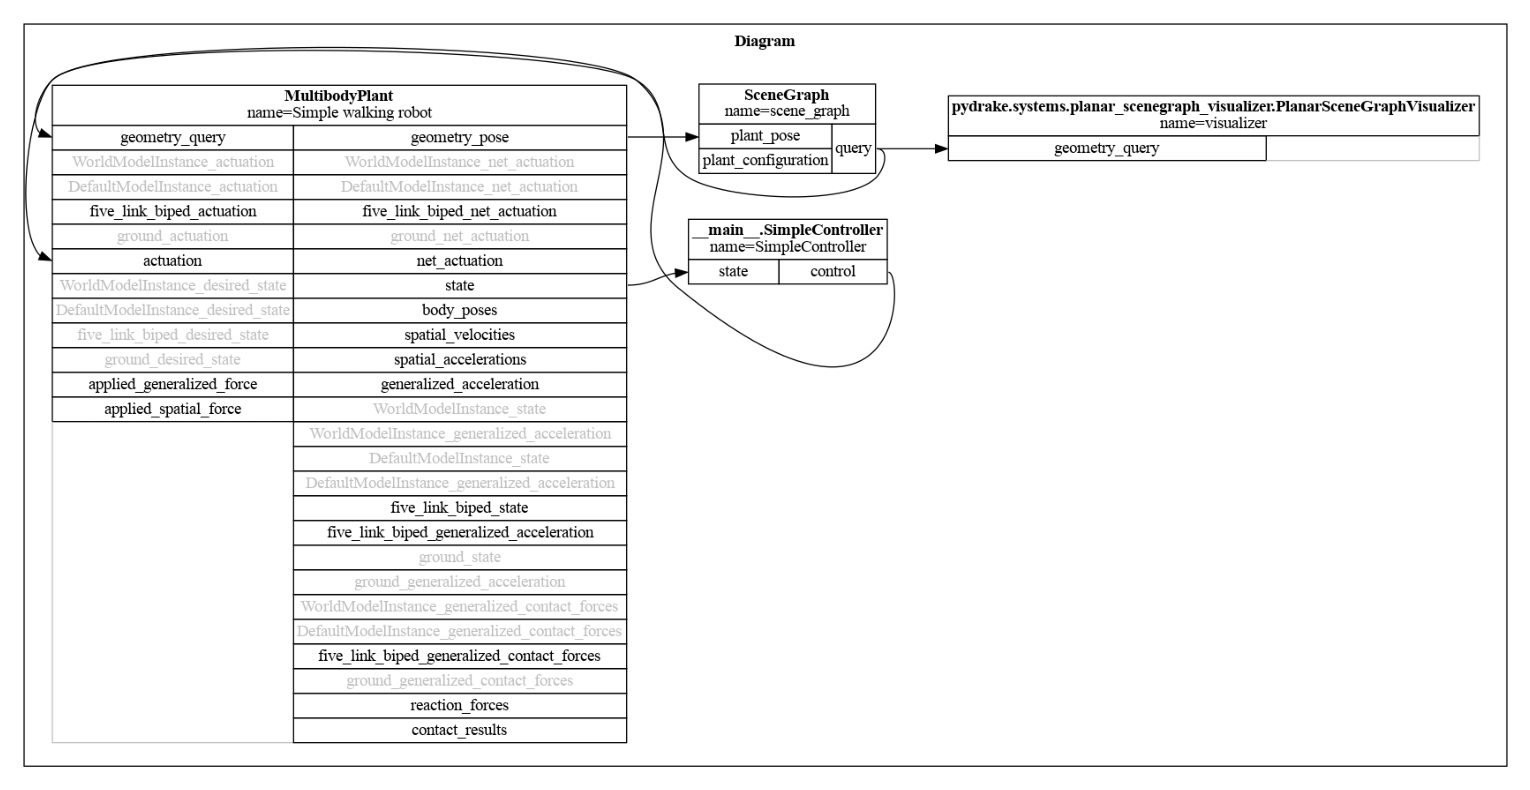

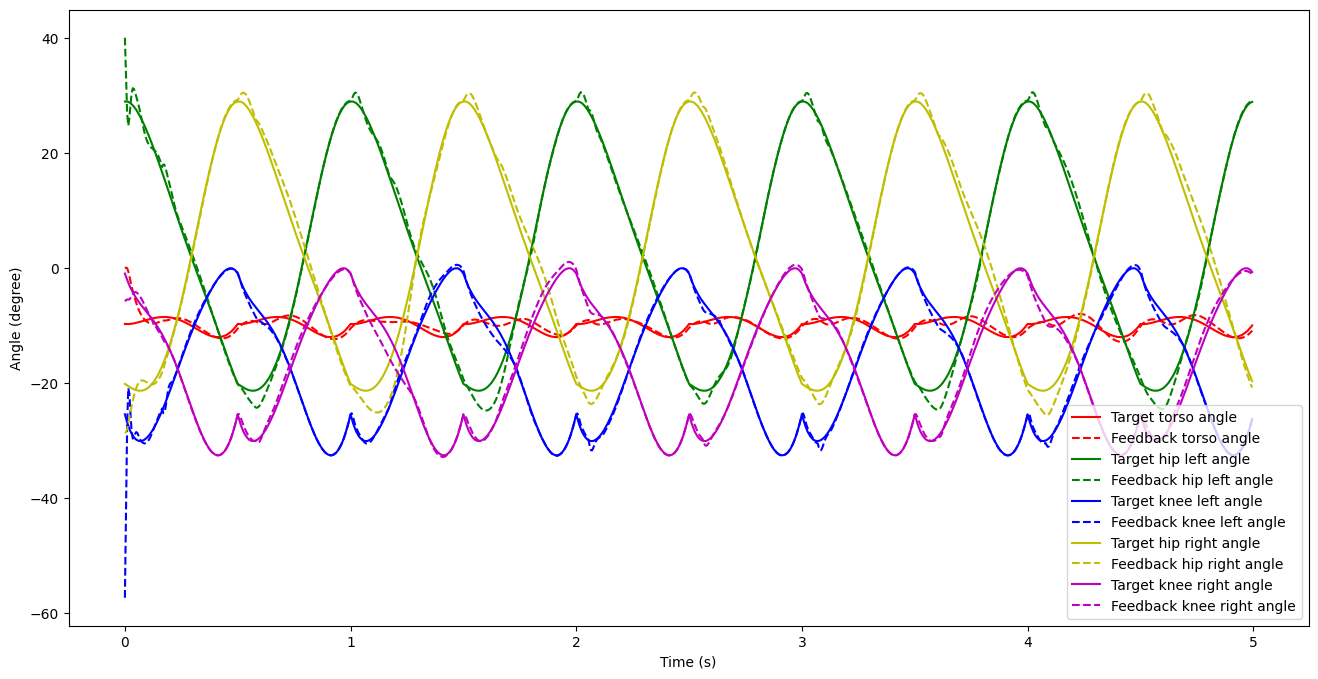

<Figure size 640x480 with 0 Axes>

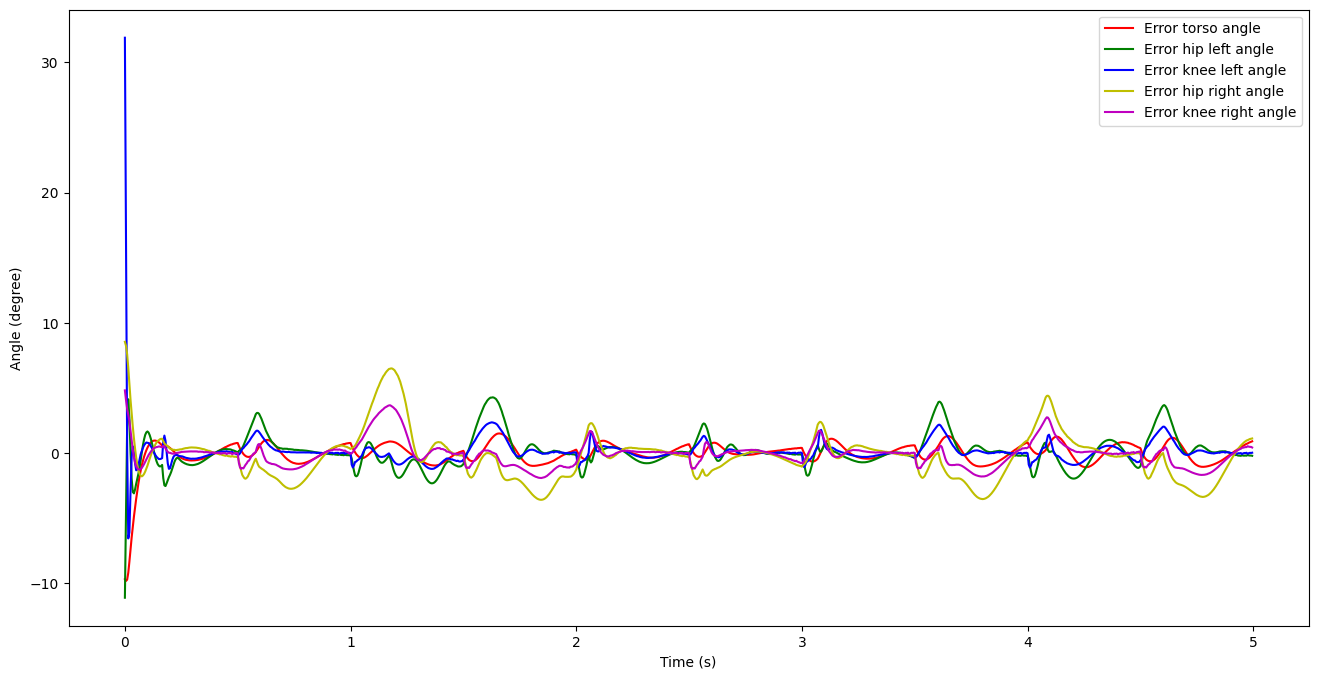

In [7]:

goal = []
feedback = []
error = []
simulate_step = 0.005

class SimpleController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("state", BasicVector(plant.num_positions() + plant.num_velocities()))
        self.DeclareVectorOutputPort("control", BasicVector(plant.num_actuators()), self.CalculateControl)
        self.load_trace()
        # PID 控制器参数
        self.Kp = [2000, 10000, 10000, 5000, 5000]
        self.Kd = [80, 60, 50, 100, 60]
        # self.Ki = [50, 30, 30, 50, 50]
        self.Ki = [0, 0, 0, 0, 0]
        self.error_integral = np.zeros(plant.num_actuators())  # 误差积分项的初始值
        self.step = self.t[1] - self.t[0]
    
    def load_trace(self):
        self.data = scipy.io.loadmat("data/trace-0.5s.mat")
        self.q = self.data['q']
        self.t = self.data['t'][0]
        self.dq = self.data['dq']
    
    def interpolation(self, x, x1, x2, y1, y2):
        return (y2-y1)*(x-x1)/(x2-x1) + y1
    
    def desired_trajectory(self, t):
        left_right_type = int(t/self.t[-1])
        t -= left_right_type*self.t[-1]
        i1, i2 = int(t//self.step), int(t//self.step+1)
        t1, t2 = i1*self.step, i2*self.step
        
        knee_left = self.interpolation( t, t1, t2, 
                                        self.q[0][i1] - self.q[1][i1],
                                        self.q[0][i2] - self.q[1][i2])
        hip_left = self.interpolation( t, t1, t2, self.q[1][i1], self.q[1][i2])
        torso = self.interpolation( t, t1, t2, self.q[2][i1], self.q[2][i2])
        hip_right = self.interpolation( t, t1, t2, self.q[3][i1], self.q[3][i2])
        knee_right = self.interpolation( t, t1, t2,
                                        self.q[4][i1] - self.q[3][i1],
                                        self.q[4][i2] - self.q[3][i2])
        
        if left_right_type % 2 == 1:
            knee_left, knee_right = knee_right, knee_left
            hip_left, hip_right = hip_right, hip_left
        
        return [torso, hip_left, knee_left, hip_right, knee_right]

    def desired_velocity(self, t):
        left_right_type = int(t/self.t[-1])
        t -= left_right_type*self.t[-1]
        index = np.argmin(np.abs(self.t - t))
        if index == 0:
            knee_left_velocity = (self.q[0][index + 1] - self.q[1][index + 1] - self.q[0][index] + self.q[1][index]) / (self.t[index + 1] - self.t[index])
            hip_left_velocity = (self.q[1][index + 1] - self.q[1][index]) / (self.t[index + 1] - self.t[index])
            torso_velocity = (self.q[2][index + 1] - self.q[2][index]) / (self.t[index + 1] - self.t[index])
            hip_right_velocity = (self.q[3][index + 1] - self.q[3][index]) / (self.t[index + 1] - self.t[index])
            knee_right_velocity = (self.q[4][index + 1] - self.q[4][index] - self.q[3][index + 1] + self.q[3][index]) / (self.t[index + 1] - self.t[index])
        elif index == len(self.t) - 1:
            knee_left_velocity = (self.q[0][index] - self.q[1][index] - self.q[0][index - 1] + self.q[1][index - 1]) / (self.t[index] - self.t[index - 1])
            hip_left_velocity = (self.q[1][index] - self.q[1][index - 1]) / (self.t[index] - self.t[index - 1])
            torso_velocity = (self.q[2][index] - self.q[2][index - 1]) / (self.t[index] - self.t[index - 1])
            hip_right_velocity = (self.q[3][index] - self.q[3][index - 1]) / (self.t[index] - self.t[index - 1])
            knee_right_velocity = (self.q[4][index] - self.q[4][index - 1] - self.q[3][index] + self.q[3][index - 1]) / (self.t[index] - self.t[index - 1])
        else:
            knee_left_velocity = (self.q[0][index + 1] - self.q[1][index + 1] - self.q[0][index - 1] + self.q[1][index - 1]) / (self.t[index + 1] - self.t[index - 1])
            hip_left_velocity = (self.q[1][index + 1] - self.q[1][index - 1]) / (self.t[index + 1] - self.t[index - 1])
            torso_velocity = (self.q[2][index + 1] - self.q[2][index - 1]) / (self.t[index + 1] - self.t[index - 1])
            hip_right_velocity = (self.q[3][index + 1] - self.q[3][index - 1]) / (self.t[index + 1] - self.t[index - 1])
            knee_right_velocity = (self.q[4][index + 1] - self.q[4][index - 1] - self.q[3][index + 1] + self.q[3][index - 1]) / (self.t[index + 1] - self.t[index - 1])
        
        if left_right_type % 2 == 1:
            knee_left_velocity, knee_right_velocity = knee_right_velocity, knee_left_velocity
            hip_left_velocity, hip_right_velocity = hip_right_velocity, hip_left_velocity
        
        return [torso_velocity, hip_left_velocity, knee_left_velocity, hip_right_velocity, knee_right_velocity]

    def CalculateControl(self, context, output):
        # 获取当前时间
        t = context.get_time()
        # 获取状态输入
        current_position = self.get_input_port().Eval(context)[7:12]
        current_velocity = self.get_input_port().Eval(context)[18:]
        
        position_error = self.desired_trajectory(t) - current_position
        velocity_error = self.desired_velocity(t) - current_velocity
        self.error_integral += position_error
        
        # 计算控制命令
        # control = self.Kp * position_error + self.Kd * velocity_error + self.Ki * self.error_integral
        control = []
        for i in range(5):
            control.append(self.Kp[i] * position_error[i] + self.Kd[i] * velocity_error[i] + self.Ki[i] * self.error_integral[i])
        output.SetFromVector(control)
        
        goal.append(self.desired_trajectory(t))
        feedback.append(current_position)
        error.append(position_error)
    
    def get_init_state(self):
        return [
            1., 0., 0., 0., 0., 0., 0.689,
            self.q[2][0] + np.pi/4, self.q[1][0] + np.pi/4, self.q[0][0] - self.q[1][0] + np.pi/4, self.q[3][0] + np.pi/4, self.q[4][0] - self.q[3][0] + np.pi/4,                 # 初始角位置    躯干、左髋、左膝、右髋、右膝
            0., 0., 0., 0., 0., 0., 
            self.dq[2][0], self.dq[1][0], self.dq[0][0] - self.dq[1][0], self.dq[3][0], self.dq[4][0] - self.dq[3][0]           # 初始角速度    躯干、左髋、左膝、右髋、右膝
        ]

def walking_build(duration=1.4, playback=True, show=True):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, simulate_step)
    parser = Parser(plant)

    # parser.AddModels('pendulum.urdf')
    parser.AddModels('simple_walking_robot.urdf')
    parser.AddModels('ground.urdf')
    plant.Finalize()
    plant.set_name('Simple walking robot')
    
    context = plant.CreateDefaultContext()
    plant.get_actuation_input_port().FixValue(context, np.zeros(plant.num_actuators()))
    
    controller = builder.AddSystem(SimpleController(plant))
    controller.set_name("SimpleController")
    builder.Connect(plant.get_state_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())
    
    T_VW = np.array([[1., 0., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
    visualizer = ConnectPlanarSceneGraphVisualizer(builder, scene_graph, T_VW=T_VW, xlim=[-8, 2],ylim=[-0.1, 3], show=False)
    visualizer.set_name("visualizer")
    if playback:
        visualizer.start_recording()

    diagram = builder.Build()
    show_diagram(diagram)
    return diagram

def simulation(diagram, duration, playback=True):
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.)
    
    visualizer = diagram.GetSubsystemByName("visualizer")

    # Fix the input port to zero.
    # context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
    plant = diagram.GetSubsystemByName("Simple walking robot")
    context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
    # plant.get_actuation_input_port().FixValue(context, [0,      # torso
    #                                                     0,          # hip left
    #                                                     0,     # knee left
    #                                                     0,      # hip right
    #                                                     0     # knee right
    #                                                     ])
    
    # 初始化位置和速度
    initial_state = diagram.GetSubsystemByName("SimpleController").get_init_state()
    # initial_state = [1., 0., 0., 0., 0., 0., 0.689, 
    #                  0.,  0.7, -1.0, -0.5, -0.1, 
    #                  0., 0., 0., 0., 0., 0., 
    #                  0., -1.7143, 1.2857, 1.7143, -1.2857 ]
    initial_state = [1., 0., 0., 0., 0., 0., 0.9, 0., 0.7, -1.0, -0.5, -0.1, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0. ]
    context.SetDiscreteState(np.concatenate([initial_state]))
    # context.SetContinuousState([initial_state])
    simulator.Initialize()
    simulator.AdvanceTo(duration)
    
    if playback:
        visualizer.stop_recording()
        ani = visualizer.get_recording_as_animation()
        return ani
    else:
        return None

def plot_record(goal, feedback ,error):
    goal_plot = [[],[],[],[],[]]
    feedback_plot = [[],[],[],[],[]]
    error_plot = [[],[],[],[],[]]
    tag = ['torso', 'hip left', 'knee left', 'hip right', 'knee right']
    for i in range(len(goal)):
        for j in range(5):
            goal_plot[j].append(goal[i][j]/np.pi*180.0)
            feedback_plot[j].append(feedback[i][j]/np.pi*180.0)
            error_plot[j].append(error[i][j]/np.pi*180.0)
    t = np.arange(0, len(goal)*simulate_step, simulate_step)
    color = ['r', 'g', 'b', 'y', 'm']
    plt.figure(figsize=(16, 8))
    for i in range(5):
        plt.plot(t, goal_plot[i], label=f"Target {tag[i]} angle", color=color[i])
        plt.plot(t, feedback_plot[i], label=f"Feedback {tag[i]} angle", color=color[i], linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degree)')
    plt.legend()
    # plt.figure()
    # for i in range(5):
    # plt.legend()
    plt.figure()
    plt.figure(figsize=(16, 8))
    plt.savefig('simple_walking_robot_trace.png')
    for i in range(5):
        plt.plot(t, error_plot[i], label=f"Error {tag[i]} angle", color=color[i])
    # plt.ylim([-30, 30])
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degree)')
    plt.legend()
    plt.savefig('simple_walking_robot_error.png')

diagram = walking_build()
ani = simulation(diagram, duration=5.0, playback=True)
plot_record(goal, feedback ,error)
HTML(ani.to_jshtml())